In [3]:
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import nltk
from nltk.util import ngrams
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.sampler import SubsetRandomSampler
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

ModuleNotFoundError: No module named 'torch'

In [2]:
train_tmp = open("hw2_data/snli_train.tsv").read().split('\n')
train_data = [row.split('\t') for row in train_tmp][1:-1]
val_tmp = open("hw2_data/snli_val.tsv").read().split('\n')
val_data = [row.split('\t') for row in val_tmp][1:-1]

In [3]:
train_s1 = [row[0] for row in train_data]
train_s2 = [row[1] for row in train_data]
val_s1 = [row[0] for row in val_data]
val_s2 = [row[1] for row in val_data]


In [4]:
train_label = [row[2] for row in train_data]
val_label = [row[2] for row in val_data]

In [5]:
#tokenize
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
#         print(type(sample))
        tokens = nltk.word_tokenize(sample.lower())
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_s1_tokens, _ = tokenize_dataset(val_s1)
pkl.dump(val_s1_tokens, open("val_s1_tokens.p", "wb"))
val_s2_tokens, _ = tokenize_dataset(val_s2)
pkl.dump(val_s2_tokens, open("val_s2_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_s1_tokens, all_train_s1_tokens = tokenize_dataset(train_s1)
train_s2_tokens, all_train_s2_tokens = tokenize_dataset(train_s2)

pkl.dump(train_s1_tokens, open("train_s1_tokens.p", "wb"))
pkl.dump(train_s2_tokens, open("train_s2_tokens.p", "wb"))


Tokenizing val data
Tokenizing train data


In [6]:
all_train_s1_tokens.extend(all_train_s2_tokens)

In [8]:
ft_home = './'
words_to_load = 500000

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((2+words_to_load, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])

In [9]:
idx2words_ft[0] = '<pad>'
idx2words_ft[1] = '<unk>'
words_ft['<pad>'] = 0
words_ft['<unk>'] = 1


In [12]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(idx2words_ft)-1)
random_token = idx2words_ft[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, idx2words_ft[random_token_id]))
print ("Token {}; token id {}".format(random_token, words_ft[random_token]))

Token id 274270 ; token ridley
Token ridley; token id 274270


In [13]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [words_ft[token] if token in words_ft else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_s1_indices = token2index_dataset(train_s1_tokens)
val_s1_indices = token2index_dataset(val_s1_tokens)
train_s2_indices = token2index_dataset(train_s2_tokens)
val_s2_indices = token2index_dataset(val_s2_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_s1_indices)))
print ("Train dataset size is {}".format(len(train_s2_indices)))
print ("Val dataset size is {}".format(len(val_s1_indices)))
print ("Val dataset size is {}".format(len(val_s2_indices)))

Train dataset size is 100000
Train dataset size is 100000
Val dataset size is 1000
Val dataset size is 1000


In [68]:
MAX_SENTENCE_LENGTH = 25
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, s1_data, s2_data, target_list):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.s1_data = s1_data
        self.s2_data = s2_data
        self.target_list = target_list
        assert (len(self.s1_data) == len(self.target_list))
        assert (len(self.s2_data) == len(self.target_list))
#         self.words_ft = words_ft

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        item = dict()
        
        item['s1_word_idx'] = self.s1_data[key][:MAX_SENTENCE_LENGTH]
        item['s2_word_idx'] = self.s2_data[key][:MAX_SENTENCE_LENGTH]
        item['label'] = self.target_list[key]
        return item


In [69]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_list, s2_list = [],[]
    label_list = []
#     length_list = []
#     print(batch)
    for datum in batch:
        label_list.append(datum['label'])
#         length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum['s1_word_idx']),
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(datum['s1_word_idx']))),
                                mode="constant", constant_values=0)
        s1_list.append(list(padded_vec))
    for datum in batch:
        padded_vec = np.pad(np.array(datum['s2_word_idx']),
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(datum['s2_word_idx']))),
                                mode="constant", constant_values=0)
        s2_list.append(list(padded_vec))
#     ind_dec_order = np.argsort(length_list)[::-1]
#     data_list = np.array(data_list)[ind_dec_order]
#     length_list = np.array(length_list)[ind_dec_order]
#     label_list = np.array(label_list)[ind_dec_order]
    label_list = [{'entailment':0,'contradiction':1,'neutral':2}[k] for k in label_list]
#     print(label_list)
    return [torch.from_numpy(np.array(s1_list)),torch.from_numpy(np.array(s2_list)), torch.LongTensor(label_list)]


In [70]:
train_loader = torch.utils.data.DataLoader(
    SNLIDataset(train_s1_indices, train_s2_indices, train_label),batch_size=BATCH_SIZE,shuffle=True,collate_fn=vocab_collate_func)

val_loader = torch.utils.data.DataLoader(
    SNLIDataset(val_s1_indices, val_s2_indices, val_label),batch_size=BATCH_SIZE,shuffle=True,collate_fn=vocab_collate_func)

In [2]:
class RNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super().__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix))
        num_ebd, emb_size = weights_matrix.shape
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, dropout=0.2, bidirectional=True)
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, dropout=0.2, bidirectional=True)
        self.tanh = nn.Tanh()
#         self.linear = nn.Linear(hidden_size*2, num_classes)
        self.mlp = nn.Sequential(
            
            nn.Linear(hidden_size*2*2,1000),
            #nn.Linear(rnn_output_dim, output_dim),
            nn.Tanh(),
            nn.Dropout(p=0.3),
            nn.Linear(1000,num_classes),
        )

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden

    def forward(self, s1, s2):
        # reset hidden state

#         batch_size = x.size()
        batch_size = BATCH_SIZE
#         print(len(s1))

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        # get embedding of characters
        s1_embed = self.embedding(s1)
        s2_embed = self.embedding(s2)
        # pack padded sequence
#         s1_embed = torch.nn.utils.rnn.pack_padded_sequence(s1_embed, lengths.numpy(), batch_first=True)
        # fprop though RNN
        s1_rnn_out, self.hidden1 = self.rnn1(s1_embed, self.hidden1)
        s2_rnn_out, self.hidden2 = self.rnn2(s2_embed, self.hidden2)
        # undo packing
#         rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        # sum hidden activations of RNN across time
        s1_rnn_out = torch.sum(s1_rnn_out, dim=1)
        s2_rnn_out = torch.sum(s2_rnn_out, dim=1)
        
        rnn_out = torch.cat([s1_rnn_out, s2_rnn_out], 1)
        
        logits = self.mlp(rnn_out)
        return logits


NameError: name 'nn' is not defined

In [100]:
def test_model(model, train=False):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    nbatch = 0
    sumloss = 0
    
    model.eval()
    # get a random sample
    if train:
        sp_loader = torch.utils.data.DataLoader(
            SNLIDataset(train_s1_indices, train_s2_indices, train_label),batch_size=BATCH_SIZE,collate_fn=vocab_collate_func,
            sampler=SubsetRandomSampler(range(10*BATCH_SIZE)))
    else:
        sp_loader = torch.utils.data.DataLoader(
            SNLIDataset(val_s1_indices, val_s2_indices, val_label),batch_size=BATCH_SIZE,collate_fn=vocab_collate_func,
            sampler=SubsetRandomSampler(range(10*BATCH_SIZE)))

    for sample in sp_loader:
        try:
            outputs = F.softmax(model(sample[0], sample[1]), dim=1)
            loss = criterion(outputs, sample[2])
            nbatch += 1
            sumloss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1].view(-1)
            total += len(predicted)
            truths = sample[2]
            correct += predicted.eq(truths.view_as(predicted)).sum().item()
        except:
            total += 0
            correct += 0
    return (100 * correct / total), sumloss/nbatch


In [20]:

model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=500, num_layers=1, num_classes=3)

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, sample in enumerate(train_loader):
#         print(len(sample['label']))
        model.train()
        optimizer.zero_grad()
        # Forward pass
        output = model(sample[0], sample[1])
        label = sample[2]
        loss = criterion(output, label)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            print(loss.item())
#             validate
            val_acc, val_los = test_model(model, train=False)
            tra_acc, tra_los = test_model(model, train=True)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

/Users/wangruofan/miniconda3/envs/nlpclass/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


1.1363707780838013
Epoch: [1/10], Step: [101/3125], Validation Acc: 36.99596774193548


KeyboardInterrupt: 

In [94]:
def train_model(model, learning_rate, num_epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    t_acc, v_acc = [], []
    t_los, v_los = [], []

    for epoch in range(num_epochs):
        for i, sample in enumerate(train_loader):
    #         print(len(sample['label']))
            model.train()
            optimizer.zero_grad()
            # Forward pass
            output = model(sample[0], sample[1])
            label = sample[2]
            loss = criterion(output, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 10 iterations
            if i > 0 and i % 200 == 0:
    #             validate
                val_acc, val_los = test_model(model, train=False)
                tra_acc, tra_los = test_model(model, train=True)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                t_acc.append(tra_acc)
                v_acc.append(val_acc)
                t_los.append(tra_los)
                v_los.append(val_los)
    return t_acc, v_acc, t_los, v_los

### Tune hidden dimension of GRU

/Users/wangruofan/miniconda3/envs/nlpclass/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


KeyboardInterrupt: 

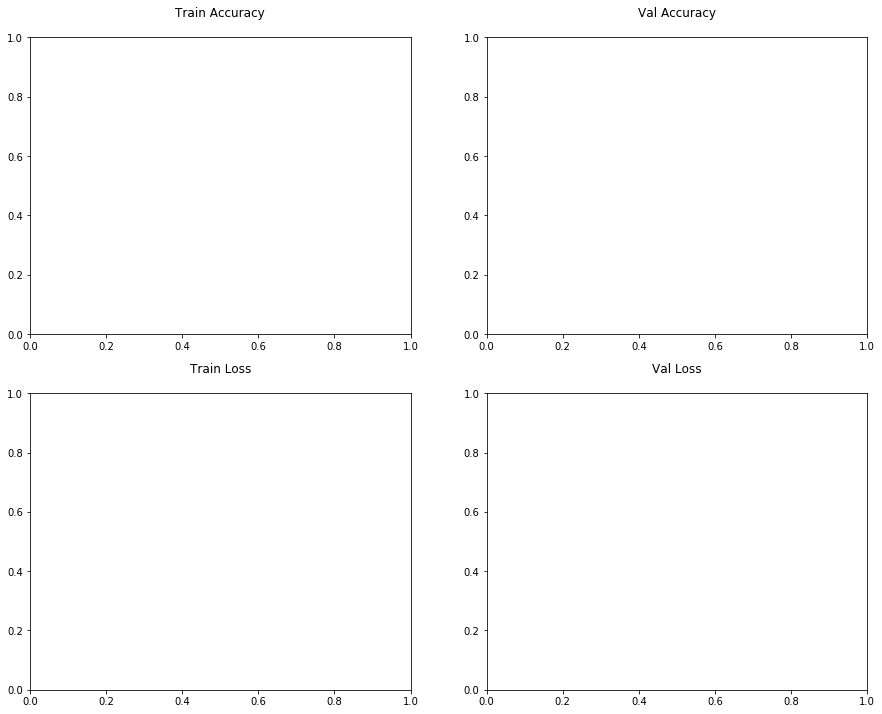

In [143]:
hidden_sizes = [250,500,750]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize= (15,12))
ax[0][0].set_title("Train Accuracy", loc="center", y=1.05)
ax[0][1].set_title("Val Accuracy", loc="center", y=1.05)
ax[1][0].set_title("Train Loss", loc="center", y=1.05)
ax[1][1].set_title("Val Loss", loc="center", y=1.05)
for h in hidden_sizes:
    model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=h, num_layers=1, num_classes=3)
    t_acc, v_acc, t_los, v_los = train_model(model, learning_rate, 5)
    ax[0][0].plot(t_acc, label="hidden size "+str(h))
    ax[0][0].legend()
    ax[0][1].plot(v_acc, label="hidden size "+str(h))
    ax[0][1].legend()
    ax[1][0].plot(t_los, label="hidden size "+str(h))
    ax[1][0].legend()
    ax[1][1].plot(v_los, label="hidden size "+str(h)) 
    ax[1][1].legend()
plt.tight_layout()    
plt.savefig("hiddensize.png")

In [1]:
model = RNN(weights_matrix=loaded_embeddings_ft, hidden_size=h, num_layers=1, num_classes=3)

NameError: name 'RNN' is not defined